# Machine Learning: Homework 1

## Download Data

In [1]:
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/x_L30.txt
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/y_L30.txt
!wget https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/T_L30.txt

--2024-06-07 14:40:15--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/x_L30.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18000000 (17M) [text/plain]
Saving to: ‘x_L30.txt’

x_L30.txt           100%[===================>]  17.17M  --.-KB/s    in 0.1s    

2024-06-07 14:40:16 (120 MB/s) - ‘x_L30.txt’ saved [18000000/18000000]

--2024-06-07 14:40:16--  https://raw.githubusercontent.com/mhibatallah/ML-for-many-body-physics-course/main/FFNN_tutorial_data/y_L30.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sen

#Define parameters

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu' #To use GPUs in PyTorch

### Data parameters: ###
L           = 30    # lattice length L
num_labels  = 2     # Number of labels (T=0 and T=infinity here)

### Hyperparameters: ###
frac_train     = 0.7    # Fraction of data used for training
frac_validation = 0.2   # Fraction of data used for validation

### Other parameters: ###
N_epochs = 1000           # Number of times to iterate through all of the data

seed=1
np.random.seed(seed)
torch.manual_seed(seed)

### Plotting parameters: ###
#Specify font sizes for plots:
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

## Import the data set


In [3]:
x_all = np.loadtxt( 'x_L30.txt', dtype='int16' )
y_all = np.loadtxt( 'y_L30.txt', dtype='int16' )
N_configs = x_all.shape[0]
N_spins   = x_all.shape[1]

### Shuffle the data and then divide into training and validation sets: ###
indices_shuffled = np.random.permutation(N_configs)
x_all = x_all[indices_shuffled,:]
y_all = y_all[indices_shuffled]

N_train = int(frac_train*N_configs)
x_train = x_all[0:N_train,:]
y_train = y_all[0:N_train]

N_validation = int(frac_validation*N_configs)
x_validation = x_all[N_train:N_train+N_validation,:]
y_validation = y_all[N_train:N_train+N_validation]

x_test = x_all[N_train+N_validation:,:]
y_test = y_all[N_train+N_validation:]
N_test = x_test.shape[0]

input_size = N_spins
output_size = num_labels

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)
x_validation = torch.tensor(x_validation, dtype = torch.float)

### One hot encoding ###
y_train_onehot = np.zeros((y_train.size, output_size))
y_train_onehot[np.arange(y_train.size),y_train] = 1
y_train_onehot = torch.tensor(y_train_onehot, dtype = torch.float)

y_validation_onehot = np.zeros((y_validation.size, output_size))
y_validation_onehot[np.arange(y_validation.size),y_validation] = 1
y_validation_onehot = torch.tensor(y_validation_onehot, dtype = torch.float)

## Define the network architecture

In [4]:
%matplotlib inline
from IPython import display

import time
import torch

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FeedforwardNN, self).__init__()

        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        #functions used within the Feedforward NN:
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)
        self.relu    = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()
    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)
        a1 = self.sigmoid(linear1_out)

        #Layer 2:
        linear2_out = self.linear2(a1)
        a2 = self.softmax(linear2_out)

        #Network output:
        aL = a2

        return aL

## Training

In [5]:
############ Function for plotting: ############
def updatePlot(epoch_list,cost_training,acc_training,cost_validation,acc_validation):

    ### Plot the cost function during training: ###
    plt.subplot(221)
    plt.plot(epoch_list,cost_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training Cost')

    ### Plot the training accuracy: ###
    plt.subplot(222)
    plt.plot(epoch_list,acc_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy')

     ### Plot the cost function during training: ###
    plt.subplot(223)
    plt.plot(epoch_list,cost_validation,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Cost')

    ### Plot the validation accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_validation,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
############ End of plotting function ############

In [13]:
def training(hidden_size, learning_rate, weight_d, mom):
  model = FeedforwardNN(input_size, output_size,hidden_size)

  epoch_list    = []
  cost_training = []
  acc_training  = []
  cost_validation = []
  acc_validation  = []

  ### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_d, momentum=mom)

  ### Cost function: ###
  cost_func = torch.nn.MSELoss()

  ### Train for several epochs: ###
  for epoch in range(N_epochs):

      optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
      NN_train_output = model(x_train) # Neural network training output
      cost_train = cost_func(NN_train_output, y_train_onehot)
      cost_train.backward() #computes the gradients
      optimizer.step() #updating the parameters

      ## Update the plot and print results every 50 epochs: ###
      if epoch % 50 == 0:

          # Validation set
          NN_validation_output = model(x_validation) # Neural network training output
          cost_valid = cost_func(NN_validation_output, y_validation_onehot)
          predicted_class_validation = np.argmax(NN_validation_output.detach().numpy(), axis=1)
          accuracy_valid = np.mean(predicted_class_validation == y_validation)

          cost_validation.append(cost_valid.detach().numpy())
          acc_validation.append(accuracy_valid)

          # Training set
          predicted_class_train = np.argmax(NN_train_output.detach().numpy(), axis=1)
          accuracy_train = np.mean(predicted_class_train == y_train)

          cost_training.append(cost_train.detach().numpy())
          acc_training.append(accuracy_train)

          epoch_list.append(epoch)

          ### Update the plot ###
          fig = plt.figure(1,figsize=(10,5))
          fig.subplots_adjust(hspace=.3,wspace=.3)
          plt.clf()
          updatePlot(epoch_list,cost_training,acc_training,cost_validation,acc_validation)
          display.display(plt.gcf())
          print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n  Validation cost %f\n  Validation accuracy %f\n" % (epoch, cost_train, accuracy_train, cost_valid, accuracy_valid) )
          display.clear_output(wait=True)
          # time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

  plt.savefig('NN_results.pdf', bbox_inches="tight")
  print("Final Training cost %f\nFinal Training accuracy %f\nFinal Validation cost %f\nFinal Validation accuracy %f\n" % (cost_train, accuracy_train, cost_valid, accuracy_valid))

  return model

a)

Final Training cost 0.007775
Final Training accuracy 0.994143
Final Validation cost 0.012869
Final Validation accuracy 0.988500



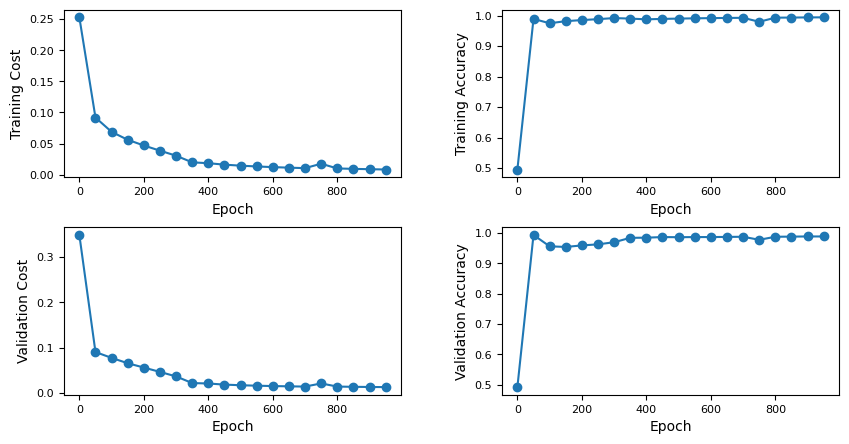

In [8]:
### Hyperparameters: ###
hidden_size = 100
learning_rate  = 1      # Learning rate for training algorithm
weight_decay = 0        # L2 regularization hyperparameter
momentum = 0                 # Stochastic Gradient Descent momentum

### Training ###
training(hidden_size, learning_rate, weight_decay, momentum)


The training accuracy and the validation accuracy exhibit the same behavior. The validation accuracy does not show a decreasing trend after some epoch, so the plots do not show a signature of overfitting.

b) Add in L2 Regularization

Final Training cost 0.278208
Final Training accuracy 0.496429
Final Validation cost 0.282739
Final Validation accuracy 0.492500



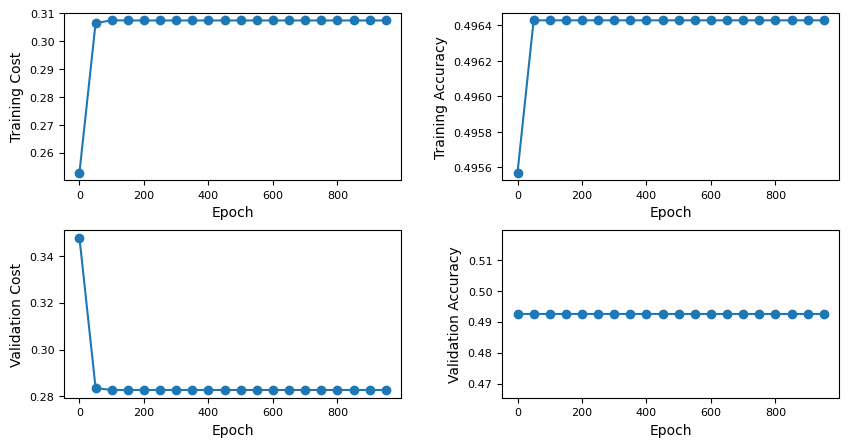

In [ ]:
### Hyperparameters: ###
hidden_size = 100
learning_rate  = 1      # Learning rate for training algorithm
weight_decay = 0.1        # L2 regularization hyperparameter
momentum = 0                 # Stochastic Gradient Descent momentum

### Training ###
training(hidden_size, learning_rate, weight_decay, momentum)

The training accuracy and validation accuracy does not change and are only 0.5, which is equivalent to random guesses. So the regularization parameter is too large.

Final Training cost 0.019402
Final Training accuracy 0.978571
Final Validation cost 0.029714
Final Validation accuracy 0.973000



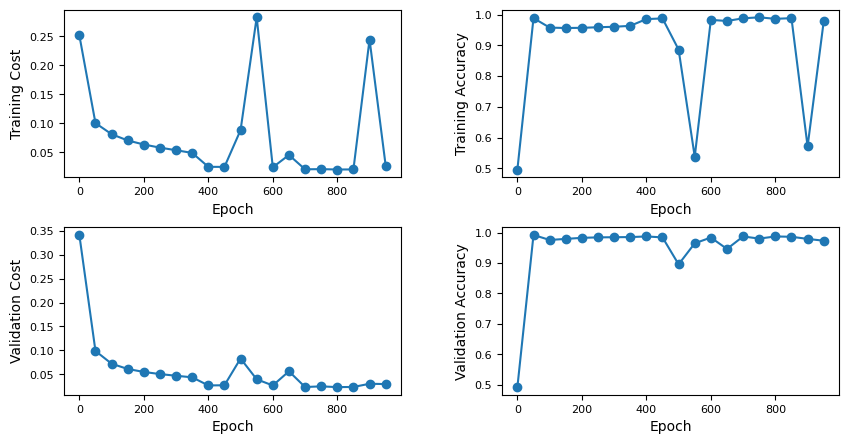

In [ ]:
### Hyperparameters: ###
hidden_size = 100
learning_rate  = 1      # Learning rate for training algorithm
weight_decay = 1e-3        # L2 regularization hyperparameter
momentum = 0                 # Stochastic Gradient Descent momentum

### Training ###
training(hidden_size, learning_rate, weight_decay, momentum)

A smaller regularization parameter leads to higher training accuracy and validation accuracy, and it also decreases the cost. The training cost has a spike and the training accuracy has a drop at epoch 550. This is probably because the learning rate is too large, and I will adjust the learning rate accordingly.

c) Adjusting other hyperparameters(learning rate, momentum, number of neurons in the hidden layer)

Final Training cost 0.039506
Final Training accuracy 0.984571
Final Validation cost 0.042240
Final Validation accuracy 0.984000



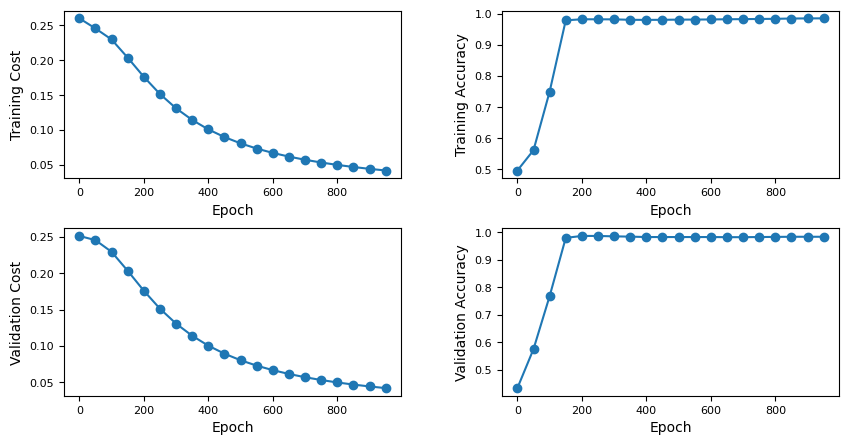

In [ ]:
### Adjust learning rate ###
hidden_size = 100
learning_rate  = 0.1      # Learning rate for training algorithm
weight_decay = 1e-4        # L2 regularization hyperparameter
momentum = 0                 # Stochastic Gradient Descent momentum

### Training ###
training(hidden_size, learning_rate, weight_decay, momentum)

Choosing a smaller learning rate results in a smoother decrease of both costs and a smoother increase of both accuracies. The training accuracy converges at around epoch 100. The final accuracies also increase and the final costs decrease.

Final Training cost 0.033659
Final Training accuracy 0.984429
Final Validation cost 0.036365
Final Validation accuracy 0.986000



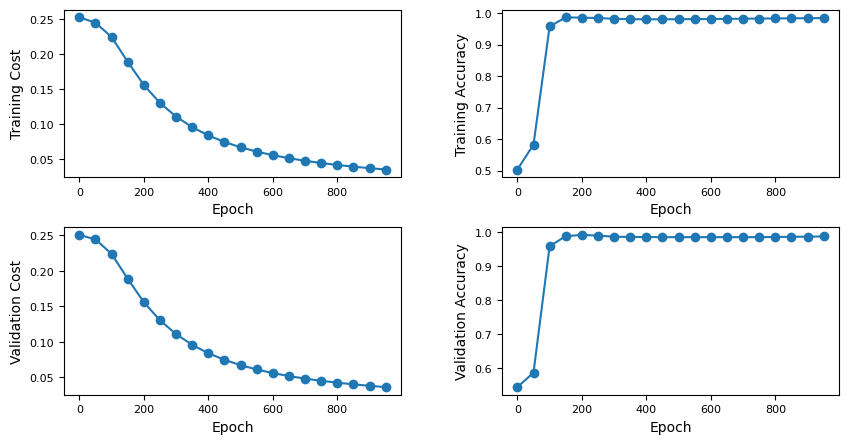

In [7]:
### Adjust momentum ###
hidden_size = 100
learning_rate  = 0.1      # Learning rate for training algorithm
weight_decay = 1e-4        # L2 regularization hyperparameter
momentum = 0.1                 # Stochastic Gradient Descent momentum

### Training ###
training(hidden_size, learning_rate, weight_decay, momentum)

The accuracies slightly increase and the cost slightly decrease. Due to the stochastic nature of the optimization, it is hard to determine whether the bettter performance is due to adding the momentum. However, it also seems like the convergence of accuracies at epoch 100 is smoother.

Final Training cost 0.029405
Final Training accuracy 0.986143
Final Validation cost 0.031095
Final Validation accuracy 0.986500



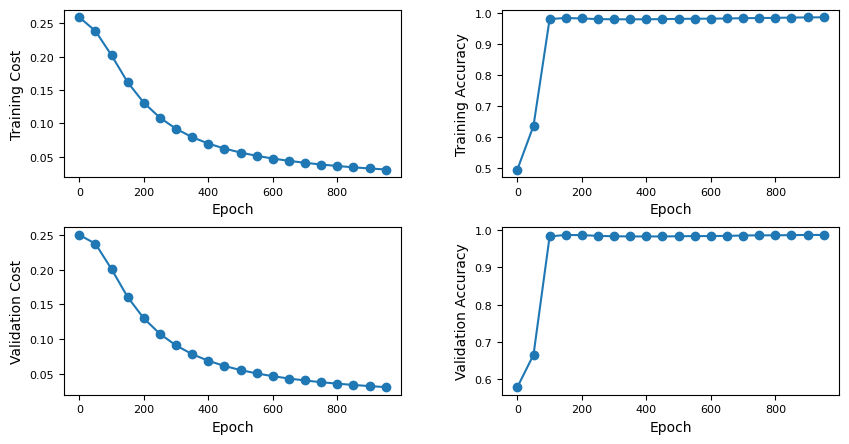

In [9]:
### Adjust hidden size ###
hidden_size = 150
learning_rate  = 0.1      # Learning rate for training algorithm
weight_decay = 1e-4        # L2 regularization hyperparameter
momentum = 0.1                 # Stochastic Gradient Descent momentum

### Training ###
training(hidden_size, learning_rate, weight_decay, momentum)

Increading the hidden size also slightly increase the accuracies and decrease the costs.

d) accuracy of the testing dataset, using the best-trained neural network

Final Training cost 0.027988
Final Training accuracy 0.985857
Final Validation cost 0.029249
Final Validation accuracy 0.986500



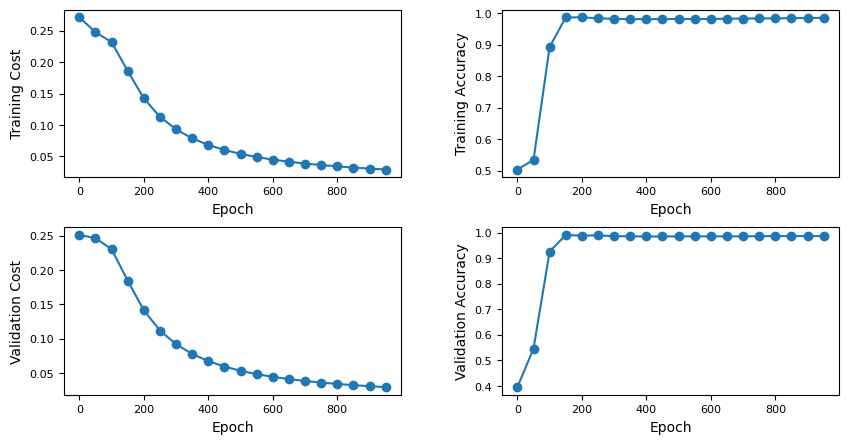

In [14]:
### Best-trained Model ###
hidden_size = 150
learning_rate  = 0.1      # Learning rate for training algorithm
weight_decay = 1e-4        # L2 regularization hyperparameter
momentum = 0.1                 # Stochastic Gradient Descent momentum

### Training ###
best_model = training(hidden_size, learning_rate, weight_decay, momentum)

In [15]:
### Store the input data as a PyTorch tensor ###
x_test = torch.tensor(x_test, dtype = torch.float)

### One hot encoding ###
y_test_onehot = np.zeros((y_test.size, output_size))
y_test_onehot[np.arange(y_test.size),y_test] = 1
y_test_onehot = torch.tensor(y_test_onehot, dtype = torch.float)


<ipython-input-15-a41fc91017a9>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype = torch.float)


In [16]:
cost_func = torch.nn.MSELoss()

NN_test_output = best_model(x_test) # Neural network training output
cost_test = cost_func(NN_test_output, y_test_onehot)
predicted_class_test = np.argmax(NN_test_output.detach().numpy(), axis=1)
accuracy_test = np.mean(predicted_class_test == y_test)
print("Final Testing cost %f\nFinal Testing accuracy %f" % (cost_test, accuracy_test))

Final Testing cost 0.030434
Final Testing accuracy 0.988000


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


The validation accuracy is 0.986500 and the testing accuracy is 0.988000. The testing accuracy is higher than the validation accuracy.

e) neural network's performance as a function of temperature

In [17]:
# Import temperature file
T_all = np.loadtxt( 'T_L30.txt', dtype='int16' )

# shuffle indices
T_all = T_all[indices_shuffled]

# divide into testing set
T_test = T_all[N_train+N_validation:]

<ipython-input-17-0ea8051727ec>:2: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  T_all = np.loadtxt( 'T_L30.txt', dtype='int16' )


In [19]:
# sort the testing data in ascending temperature
sorted_indices = np.argsort(T_test)

# Sort all arrays according to the sorted indices
x_test = x_test[sorted_indices]
y_test = y_test[sorted_indices]
T_test = T_test[sorted_indices]

In [20]:
### Store the input data as a PyTorch tensor ###
x_test = torch.tensor(x_test, dtype = torch.float)

### One hot encoding ###
y_test_onehot = np.zeros((y_test.size, output_size))
y_test_onehot[np.arange(y_test.size),y_test] = 1
y_test_onehot = torch.tensor(y_test_onehot, dtype = torch.float)

NN_test_output = best_model(x_test) # Neural network training output

<ipython-input-20-3a11a5bfa424>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype = torch.float)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [27]:
accuracy_T = np.zeros(100)
average_m = np.zeros(100)
T = np.zeros(100)

for i in range(100):
  x_data = x_test[i*10 : (i + 1) * 10]
  y_data = y_test[i*10 : (i + 1) * 10]
  data_output = NN_test_output[i*10 : (i + 1) * 10]

  data_predicted_class = np.argmax(data_output.detach().numpy(), axis=1)

  accuracy_T[i] = np.mean(data_predicted_class == y_data)
  average_m[i] = np.mean(data_predicted_class)
  T[i] = np.mean(T_test[i*10 : (i + 1) * 10])

<Figure size 1000x500 with 0 Axes>

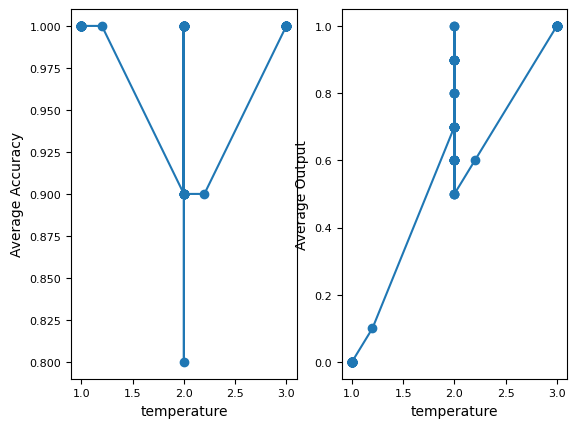

<Figure size 1000x500 with 0 Axes>

In [29]:
plt.subplot(121)
plt.plot(T,accuracy_T,'o-')
plt.xlabel('temperature')
plt.ylabel('Average Accuracy')

plt.subplot(122)
plt.plot(T,average_m,'o-')
plt.xlabel('temperature')
plt.ylabel('Average Output')

fig = plt.figure(2,figsize=(10,5))
fig.subplots_adjust(hspace=.3,wspace=.3)
display.display(plt.gcf())

There is a lot of noise in the data, since the testing set only consists of 1000 configurations. The average output vs. temperature resembles Fig.1 (B) in the refernce paper, and the average accuracy vs. temperature resembles Fig.1 (C). The testing accuracy drops at temperature ~2J, which is the critical temperature.